# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [73]:
import pickle
import csv
import matplotlib.pyplot as plt

# Loading Udacity-provided Pickle data
training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Bringing in sign names for labelling
sign_names = []
with open('signnames.csv') as sign:
    signname_reader = csv.DictReader(sign)
    sign_names = [row['SignName'] for row in signname_reader]

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Dataset

In [161]:
import numpy as np
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# Image data shape
image_shape = X_train[0].shape

# No. of unique classes
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of vaidation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of vaidation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory Visualization of the Dataset

The German Traffic Signs dataset is visualised in the below histogram. It is split into 43 categories of signs, with the number of images in each category on the y-axis. Note the extremely unequal distribution of the dataset. This can and will introduce bias into the training model, and will be addressed below. Also, a low of ~200 examples for some classes is simply too low, and will need to be augmented.

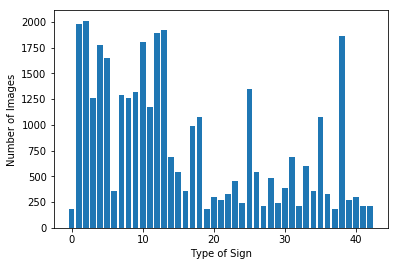

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Grabbing sign labels and unique counts of each sign type in the dataset

types = range(n_classes)
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(types, counts, width=0.8, align='center')
plt.ylabel('Number of Images')
plt.xlabel('Type of Sign')
plt.show()

### Data Preparation and Pre-processing

While the data can indeed simply be inserted into the model to begin training, it would be to our benefit to process the data as follows:

#### 1. Grayscaling
Grayscaling reduces the image to a single layer instead of 3 RGB channels, drastically reducing the number of variables the network has to deal with. This results in vastly improved processing times. While loss of information due to loss of colour could be a concern, my tests with both RGB and BW images show no significant difference in performance.

#### 2. Equalisation
Equalisation of the image helps improve contrast and provides clearer, more well-defined edges. I initially used OpenCV's histogram equalisation, but found the results to be blurry and of poor contrast. skimage's adaptive CLAHE implementation took longer to process, but gave a far superior result.

#### 3. Normalisation
Normalisation involves scaling the image's intensity range from (0, 255) to (-1, 1). Smaller values with means about 0 prevent our gradients from going out of control and finding incorrect local minima.

#### 4. Augmentation (Transformation)
Due to the low number of examples from some classes, I've chosen to re-balance the dataset to prevent bias in the mode. There after, I tripled the size of the dataset over all classes, including the ones already heavily represented. I initially attempted penalised classification to make up for the dataset imbalance, but found good ol' data augmentation more effective.

#### 5. Shuffling
Rather self-explanatory - shuffles the dataset around so that the model doesn't train itself on the ORDER of the images instead of the features.


### Grayscaling, Equalisation and Normalisation
My batch preprocess function is as follows. I began with conversion to grayscale, contrast limited adaptive histogram equalisation and normalisation from -1 to 1.

I initially used OpenCV's histogram equalisation, but found skimage's CLAHE implementation gave a much better result with more defined edges.

In [4]:
from skimage import exposure
from sklearn.utils import shuffle
from skimage import exposure
import cv2

def batchPreprocess(X):
    X_norm = []  
    for image in X:
            bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            equ = exposure.equalize_adapthist(bw)
            equ = (equ * 2.0/equ.max())
            equ = np.reshape(equ,(32,32,1))-1
            X_norm.append(equ)
    return np.array(X_norm)

### Augmentation (Transformation)
Here, we will employ rotation (within a certain degree range) and warping through projective transforms (skimage). Projective transforms were chosen due to their similarity to changes in camera perspective.

Credits to Alex for helping me figure out projective transforms! His code and write-up helped clarify the frankly rather confusing usage of skimage projective transforms. His blog [here](http://navoshta.com/).

NOTE: In earlier testing, doubling the dataset size without re-balancing it already yielded an accuracy of 95% on the validation data. While that seems nice, there is a high chance that the incorrect 5% stems from under-represented classes, rendering the prediction useless.

In [198]:
from skimage.transform import ProjectiveTransform
from skimage.transform import rotate
from skimage.transform import warp

def randomTransform(image, intensity):
    
    # Rotate image within a set range, amplified by intensity of overall transform.
    rotation = 20 * intensity
    # print(image.shape)
    rotated = rotate(image, np.random.uniform(-rotation,rotation), mode = 'edge')
    
    # Projection transform on image, amplified by intensity.
    image_size = image.shape[0]
    magnitude = image_size * 0.3 * intensity
    tl_top = np.random.uniform(-magnitude, magnitude)     # Top left corner, top margin
    tl_left = np.random.uniform(-magnitude, magnitude)    # Top left corner, left margin
    bl_bottom = np.random.uniform(-magnitude, magnitude)  # Bottom left corner, bottom margin
    bl_left = np.random.uniform(-magnitude, magnitude)    # Bottom left corner, left margin
    tr_top = np.random.uniform(-magnitude, magnitude)     # Top right corner, top margin
    tr_right = np.random.uniform(-magnitude, magnitude)   # Top right corner, right margin
    br_bottom = np.random.uniform(-magnitude, magnitude)  # Bottom right corner, bottom margin
    br_right = np.random.uniform(-magnitude, magnitude)   # Bottom right corner, right margin
    
    transform = ProjectiveTransform()
    transform.estimate(np.array((
            (tl_left, tl_top),
            (bl_left, image_size - bl_bottom),
            (image_size - br_right, image_size - br_bottom),
            (image_size - tr_right, tr_top))),
            np.array((
            (0, 0),
            (0, image_size),
            (image_size, image_size),
            (image_size, 0)
            )))
    transformed = warp(rotated, transform, output_shape = (image_size, image_size), order = 1, mode = 'edge')
    return transformed

def batchAugment(X, y, multiplier = 2):
    X_train_aug = []
    y_train_aug = []
    for i in range(len(X)):
        for j in range(multiplier):
            augmented = randomTransform(X[i], 0.5)
            X_train_aug.append(augmented)
            y_train_aug.append(y[i])
        X_train_aug.append(X[i])
        y_train_aug.append(y[i])
        
    X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)
    print("New augmented size is: ", len(X_train_aug))
    return X_train_aug, y_train_aug

### Altogether Now
Mini pipeline of the pre-processing phase.

In [6]:
# Processing both training and validation sets
X_train_proc = batchPreprocess(X_train)
X_valid_proc = batchPreprocess(X_valid)

print("Pre-processing complete!")

Pre-processing complete!


Rebalancing based on representation of classes.

In [50]:
unique, counts = np.unique(y_train, return_counts=True)
print("Original distribution of classes: ", counts)
multiplier = [int(round(max(counts)/i)) for i in counts] # Required multiplier for each class augmentation.
print("Multipliers for each class: ", multiplier)
multiplier = [i-2 for i in multiplier]

X_train_aug = X_train_proc
y_train_aug = y_train

for i in types:
    if multiplier[i] > 0: # Ignore classes which don't need oversampling
        X_train_add = []
        y_train_add = []
        index = np.where(y_train==i)
        for j in index:
            X_train_add.append(X_train_proc[j])
            y_train_add.append(y_train[j])
        X_train_add = np.array(X_train_add)
        X_train_add = np.reshape(X_train_add, (len(index[0]),32,32,1))
        y_train_add = np.array(y_train_add)
        y_train_add = np.reshape(y_train_add, (len(index[0])))
    
        print("Class: ", i+1)
        X_train_add, y_train_add = batchAugment(X_train_add, y_train_add, multiplier[i])
        X_train_aug = np.vstack((X_train_aug, X_train_add))
        print("New total dataset size: ",len(X_train_aug))
        y_train_aug = np.append(y_train_aug, y_train_add)
        print("")


unique, counts = np.unique(y_train_aug, return_counts=True)
print("New distribution of classes: ", counts)

Original distribution of classes:  [ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920  690
  540  360  990 1080  180  300  270  330  450  240 1350  540  210  480  240
  390  690  210  599  360 1080  330  180 1860  270  300  210  210]
Multipliers for each class:  [11, 1, 1, 2, 1, 1, 6, 2, 2, 2, 1, 2, 1, 1, 3, 4, 6, 2, 2, 11, 7, 7, 6, 4, 8, 1, 4, 10, 4, 8, 5, 3, 10, 3, 6, 2, 6, 11, 1, 7, 7, 10, 10]
Class:  1
New augmented size is:  1800
36599

Class:  7
New augmented size is:  1800
38399

Class:  15
New augmented size is:  1380
39779

Class:  16
New augmented size is:  1620
41399

Class:  17
New augmented size is:  1800
43199

Class:  20
New augmented size is:  1800
44999

Class:  21
New augmented size is:  1800
46799

Class:  22
New augmented size is:  1620
48419

Class:  23
New augmented size is:  1650
50069

Class:  24
New augmented size is:  1350
51419

Class:  25
New augmented size is:  1680
53099

Class:  27
New augmented size is:  1620
54719

Class:  28
New aug

Histogram of the new distribution. Better! But would under-sampling the higher classes help?

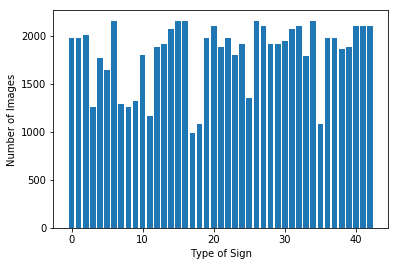

In [51]:
plt.bar(types, counts, width=0.8, align='center')
plt.ylabel('Number of Images')
plt.xlabel('Type of Sign')
plt.show()

Multiplying the entire dataset.

In [53]:
# Triple the dataset size by rotation and transformation
X_train_aug, y_train_aug = batchAugment(X_train_aug, y_train_aug, 1)    

print("Augmentation complete!")

New augmented size is:  234621
Augmentation complete!


### Visualisation of the Pre-processing Steps

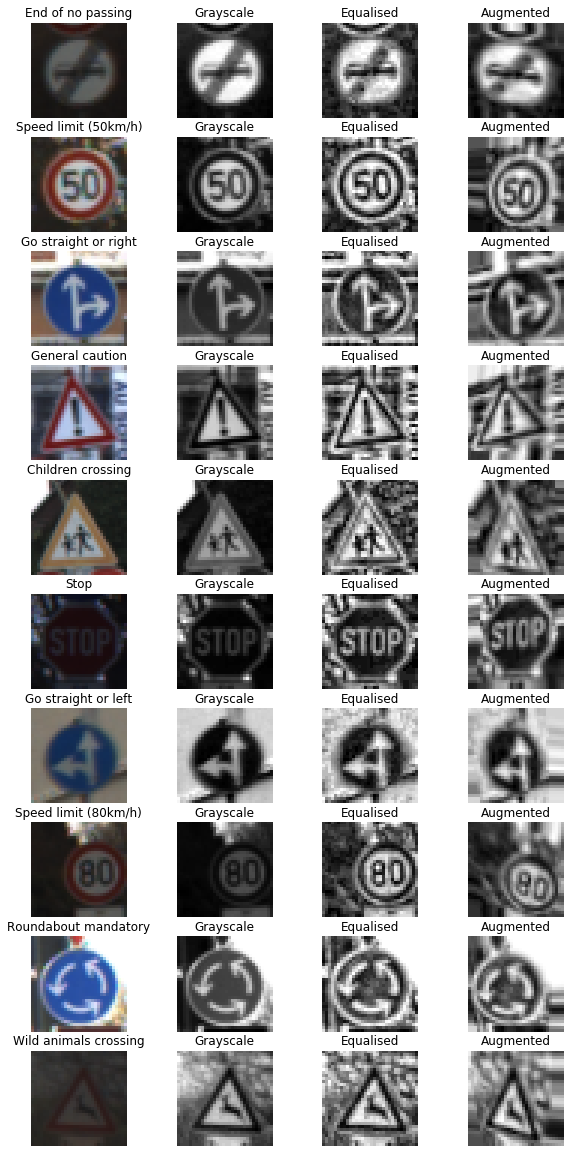

In [54]:
fig = plt.figure(figsize=(10,90))
plot = 1

for i in np.random.choice(types, 10):
    index = np.where(y_train==i)
    
    image = X_train[index[0][20]].squeeze()
    ax1 = fig.add_subplot(43,4,plot)
    ax1.set_title(sign_names[i])
    plt.axis('off')
    plt.imshow(image)
    
    bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ax2 = fig.add_subplot(43,4,plot+1)
    ax2.set_title('Grayscale')
    plt.axis('off')
    plt.imshow(bw, cmap='gray')
    
    equ = exposure.equalize_adapthist(bw)
    ax3 = fig.add_subplot(43,4,plot+2)
    ax3.set_title('Equalised')
    plt.axis('off')
    plt.imshow(equ, cmap='gray')
    
    proc = randomTransform(equ, 0.5)
    ax4 = fig.add_subplot(43,4,plot+3)
    ax4.set_title('Augmented')
    plt.axis('off')
    plt.imshow(proc, cmap='gray')
    
    plot += 4
    

----

## Model Architecture and Testing

Implementation of the LeNet-5 architecture from the lab. Only changes made to this model were the output shape (43 classes instead of 10) and the network parameters.

Here, I attempted to address the unequal distribution of data by implementing a weighted cross entropy loss, heavily penalising mistakes on poorly represented classes, making the model 'pay more attention' to these examples. This didn't go very well, as outlined in README.md.

### Model Architecture

In [55]:
from tensorflow.contrib.layers import flatten
import tensorflow as tf

def conv2d(x, W, b, strides=1, padding='SAME'):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return x

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    dropout = 0.85
    n_classes = 43
    
    #weight => [filter_size_height, filter_size_width, color_channels, k_output]))
    
    weights = {
        'wc1': tf.Variable(tf.truncated_normal([5, 5, 1, 6], stddev=sigma)),
        'wc2': tf.Variable(tf.truncated_normal([5, 5, 6, 16], stddev=sigma)),
        'wd1': tf.Variable(tf.truncated_normal([400, 120], stddev=sigma)),
        'wd2': tf.Variable(tf.truncated_normal([120, 84], stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([84, n_classes], stddev=sigma))}

    biases = {
        'bc1': tf.Variable(tf.truncated_normal([6], stddev=sigma)),
        'bc2': tf.Variable(tf.truncated_normal([16], stddev=sigma)),
        'bd1': tf.Variable(tf.truncated_normal([120], stddev=sigma)),
        'bd2': tf.Variable(tf.truncated_normal([84], stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([n_classes], stddev=sigma))}
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # Stride for each dimension: [batch, height, width, depth]
    
    x = conv2d(x, weights['wc1'], biases['bc1'], 1, 'VALID')
    
    # TODO: Activation.
    
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    
    x = maxpool2d(x)

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    
    x = conv2d(x, weights['wc2'], biases['bc2'], 1, 'VALID')
    
    # TODO: Activation.
    
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    
    x = maxpool2d(x)
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    
    x = tf.reshape(x, [-1, weights['wd1'].get_shape().as_list()[0]])   
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.

    x = tf.add(tf.matmul(x, weights['wd1']), biases['bd1'])

    # TODO: Activation.
    
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, dropout)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    
    x = tf.add(tf.matmul(x, weights['wd2']), biases['bd2'])
    
    # TODO: Activation.
    
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, dropout)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    x = tf.add(tf.matmul(x, weights['out']), biases['out'])
    
    return x

## Features and Labels
`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [56]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

### Parameters
Setting parameters such as EPOCH, BATCH_SIZE and learning rate.

In [62]:
EPOCHS = 20
BATCH_SIZE = 128
rate = 0.0009

## Training Pipeline
Largely unchanged from the LeNet lab model.

In [63]:
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluates how well the loss and accuracy of the model for a given dataset.

In [64]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Actual training occurs here.

In [65]:
import time

X_train_proc = X_train_aug
y_train = y_train_aug

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_proc)
    
    print("Training with {} inputs...".format(len(X_train_proc)))
    print()
    for i in range(EPOCHS):
        start_time =  time.time()
        X_train_proc, y_train = shuffle(X_train_proc, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_proc[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        validation_accuracy = evaluate(X_valid_proc, y_valid)
        print("=========================")
        print(" ")
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Time Taken = {:.2f} sec".format(time.time() - start_time))
        print()
    print("=========================")

    saver.save(sess, './lenet')
    print("Model saved")

Training with 234621 inputs...

 
EPOCH 1 ...
Validation Accuracy = 0.862
Time Taken = 21.52 sec

 
EPOCH 2 ...
Validation Accuracy = 0.899
Time Taken = 22.75 sec

 
EPOCH 3 ...
Validation Accuracy = 0.922
Time Taken = 23.36 sec

 
EPOCH 4 ...
Validation Accuracy = 0.934
Time Taken = 23.72 sec

 
EPOCH 5 ...
Validation Accuracy = 0.943
Time Taken = 24.50 sec

 
EPOCH 6 ...
Validation Accuracy = 0.937
Time Taken = 24.38 sec

 
EPOCH 7 ...
Validation Accuracy = 0.949
Time Taken = 24.57 sec

 
EPOCH 8 ...
Validation Accuracy = 0.946
Time Taken = 25.69 sec

 
EPOCH 9 ...
Validation Accuracy = 0.950
Time Taken = 26.08 sec

 
EPOCH 10 ...
Validation Accuracy = 0.949
Time Taken = 26.39 sec

 
EPOCH 11 ...
Validation Accuracy = 0.952
Time Taken = 27.20 sec

 
EPOCH 12 ...
Validation Accuracy = 0.957
Time Taken = 28.01 sec

 
EPOCH 13 ...
Validation Accuracy = 0.954
Time Taken = 28.39 sec

 
EPOCH 14 ...
Validation Accuracy = 0.959
Time Taken = 28.13 sec

 
EPOCH 15 ...
Validation Accuracy = 0.

---

## Step 3: Test a Model on New Images
Using the provided test.p test set, the model was re-run on existing parameters.

### Preprocess the Images
Test set was preprocessed like all other images.

In [74]:
X_test_proc = batchPreprocess(X_test)

### Test Accuracy
Model achieved 93% on the test set, which showed it generalised reasonably well. Could be better, but in the interest of time, I'll have to stop here.

In [75]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_proc, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.932


### A Closer Look at the Test Set
The model managed to get all 5 chosen images from the test set, and with reasonably high confidence to boot. This is pretty encouraging, considering this is a previously unseen set!

In [157]:
top_k_operation = tf.nn.top_k(logits, 5)
sample = X_test_proc[0:5]
original = X_test[0:5]

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k_output = sess.run(top_k_operation, feed_dict={x: sample})

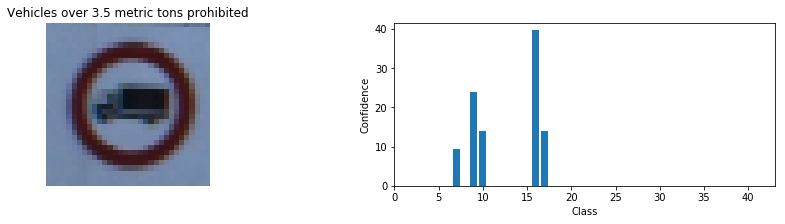

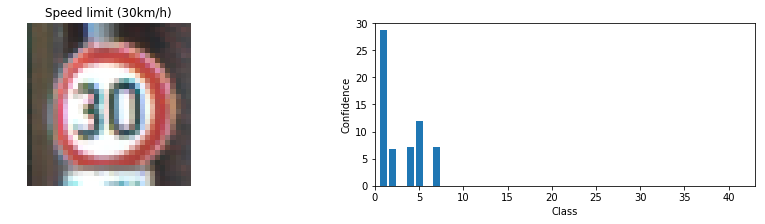

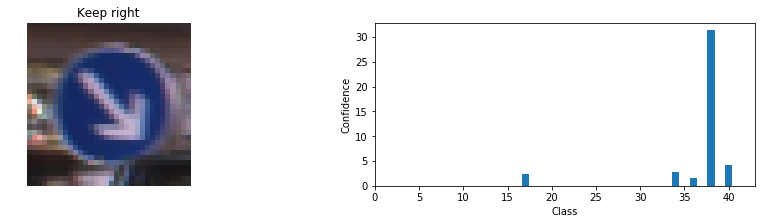

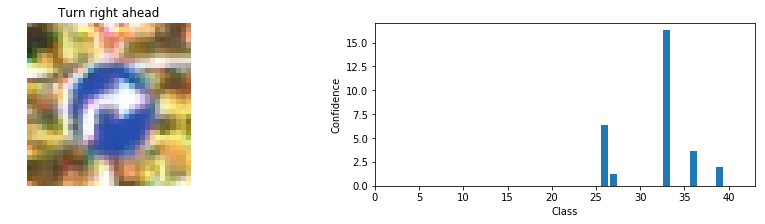

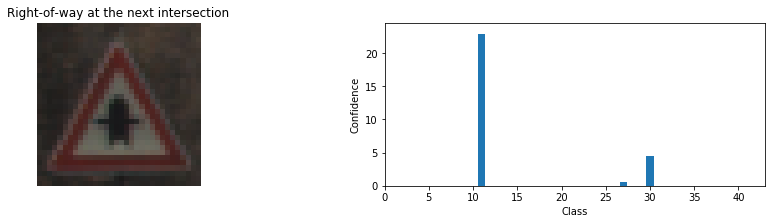

In [164]:
for i in range(len(original)):
    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    ax = ax.ravel()
    
    ax[1].bar(top_k_output.indices[i], top_k_output.values[i])
    plt.ylabel("Confidence")
    plt.xlabel("Class")
    plt.xlim([0,43])
    plt.ylim(bottom=0)
    ax[0].axis('off')
    ax[0].set_title(sign_names[y_test[i]])
    ax[0].imshow(original[i])

### Test Set Pulled From The Web
The following are 6 images I pulled from the web. The only requirements I set were that they were German, and already existed in the signnames.csv database. Throwing in a completely new, never-before-seen sign with no respective label would be rather unfair.

Note image 6, which is a composition of 13: yield and 40: roundabout. I was curious to see how the model would react to a curveball like this. Let's see.

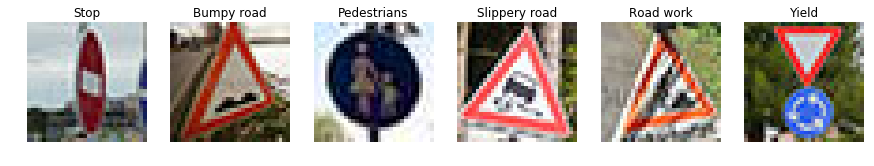

In [191]:
import glob

X_web = []
y_web = [14, 22, 27, 23, 25, 13]
for filename in glob.glob('test_web/*.jpg'): #assuming gif
    im=plt.imread(filename)
    X_web.append(im)
    
fig, ax = plt.subplots(1,6, figsize=(15,10))
for i in range(len(X_web)):
    ax[i].axis('off')
    ax = ax.ravel()
    ax[i].imshow(X_web[i])
    ax[i].set_title(sign_names[y_web[i]])


Preprocessing and evaluating...

In [197]:
X_web = np.asarray(X_web)
X_web_proc = batchPreprocess(X_web)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_web_proc, y_web)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.167


Ouch! Let's see what went wrong.

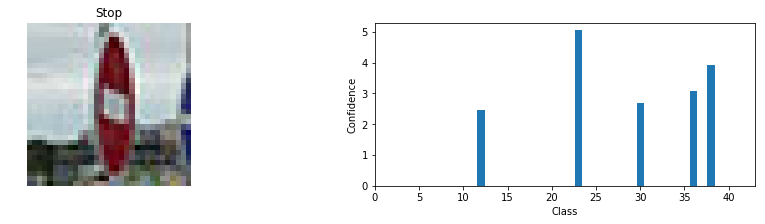

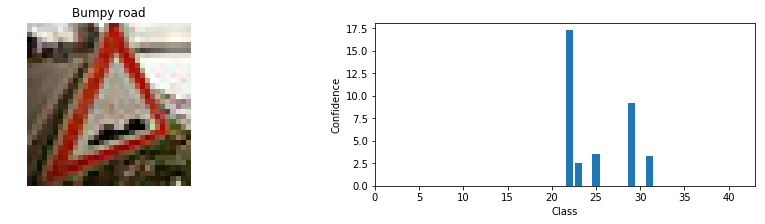

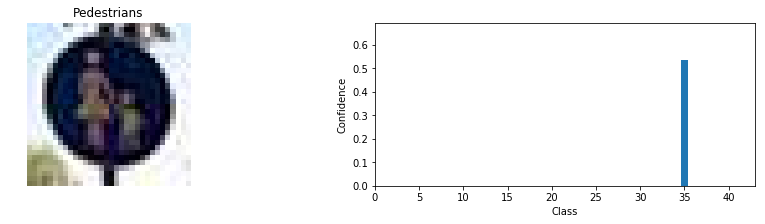

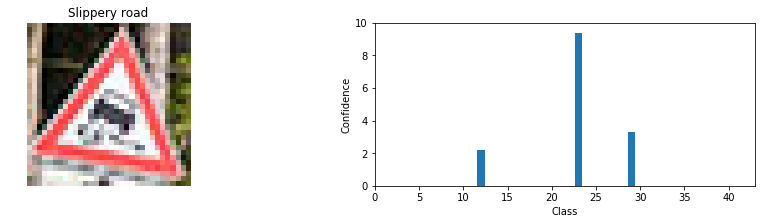

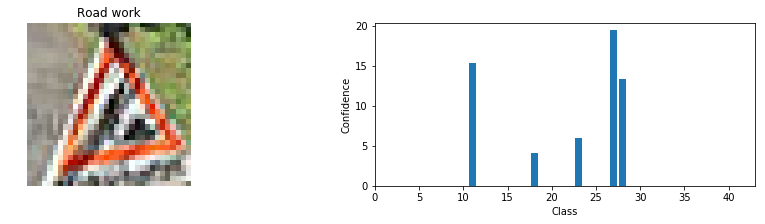

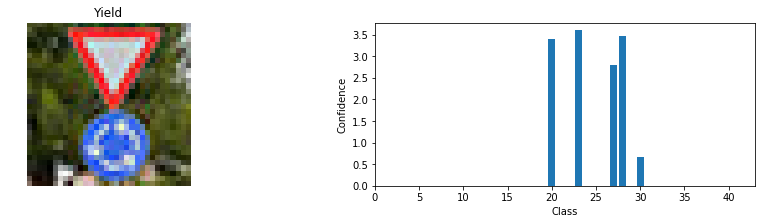

In [196]:
top_k_operation = tf.nn.top_k(logits, 5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k_output = sess.run(top_k_operation, feed_dict={x: X_web_proc})

for i in range(len(X_web)):
    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    ax = ax.ravel()
    
    ax[1].bar(top_k_output.indices[i], top_k_output.values[i])
    plt.ylabel("Confidence")
    plt.xlabel("Class")
    plt.xlim([0,43])
    plt.ylim(bottom=0)
    ax[0].axis('off')
    ax[0].set_title(sign_names[y_web[i]])
    ax[0].imshow(X_web[i])

Look like the model only got Bumpy road and Slippery road right. Understandable, given these were the only two clear signs.

Road works and yield/roundabout were both completely off the mark. Perhaps more training with obstructed/shadowed/compound signs would have **yielded** (sorry) better results.

Perhaps dialing up my intensity for warping during my ```batchAugment()``` stage would have helped with the Stop sign, giving better recognition to objects that were clearly no longer circular.

Not sure what happened with pedestrians either. It seemed REALLY confident about the sign being Ahead only, which would no doubt spell disaster for said pedestrians.